<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><span><a href="#train-val-test" data-toc-modified-id="train-val-test-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>train-val-test</a></span></li><li><span><a href="#word-embedding" data-toc-modified-id="word-embedding-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>word embedding</a></span></li><li><span><a href="#tokenizer" data-toc-modified-id="tokenizer-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>tokenizer</a></span></li><li><span><a href="#Max-Sequence-Length" data-toc-modified-id="Max-Sequence-Length-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Max Sequence Length</a></span></li></ul></li><li><span><a href="#Flattened-word-embeddings-plus-dense-layers" data-toc-modified-id="Flattened-word-embeddings-plus-dense-layers-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Flattened word embeddings plus dense layers</a></span></li><li><span><a href="#CNNs" data-toc-modified-id="CNNs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CNNs</a></span><ul class="toc-item"><li><span><a href="#global-max-pooling" data-toc-modified-id="global-max-pooling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>global max pooling</a></span></li><li><span><a href="#multi-layer-CNN-with-max-pooling" data-toc-modified-id="multi-layer-CNN-with-max-pooling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>multi-layer CNN with max pooling</a></span></li><li><span><a href="#k-max-pooling" data-toc-modified-id="k-max-pooling-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>k-max pooling</a></span></li><li><span><a href="#CNN-summary" data-toc-modified-id="CNN-summary-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CNN summary</a></span></li></ul></li><li><span><a href="#RNN---bidirectional-LSTM" data-toc-modified-id="RNN---bidirectional-LSTM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>RNN - bidirectional LSTM</a></span></li><li><span><a href="#Bert" data-toc-modified-id="Bert-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bert</a></span><ul class="toc-item"><li><span><a href="#tokenizer" data-toc-modified-id="tokenizer-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>tokenizer</a></span></li><li><span><a href="#feature-based-approach" data-toc-modified-id="feature-based-approach-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>feature-based approach</a></span></li><li><span><a href="#fine-tuning-approach" data-toc-modified-id="fine-tuning-approach-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>fine tuning approach</a></span></li></ul></li></ul></div>

In [9]:
from path import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', -1)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score

In [55]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Embedding, Lambda
from keras.layers import ZeroPadding1D, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Conv1D
from keras.layers import Dropout, Activation
from keras.layers import Add
from keras.layers.merge import Concatenate
from keras.optimizers import Adam

In [108]:
# helper function to plot learning curves
def plot_learning_curve(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.subplots_adjust(top=0.85, wspace=0.3)

    epochs = len(history.epoch)
    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, int(1 + epochs/10.)))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, int(1 + epochs/10.)))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

# Preparation

## train-val-test

In [4]:
bills = pd.read_csv('US-Legislative-congressional_bills_18.1.csv', 
                    usecols=['description','majortopic'])
bills.dropna(inplace=True)

bills['majortopic'] = bills['majortopic'].astype(int)
bills = bills[(bills['majortopic'] != 99) & (bills['majortopic']!=23)]

relabel topics from 0:

In [5]:
nconvert_keys = sorted(bills['majortopic'].unique())
nconvert_values = range(len(nconvert_keys))
dict_nconvert = dict(zip(nconvert_keys, nconvert_values))

In [6]:
bills['topic0'] = bills['majortopic'].map(dict_nconvert)

In [7]:
dict_number_topic0 = {0: 'Macroeconomics',
                      1: 'Civil Rights',
                      2: 'Health',
                      3: 'Agriculture',
                      4: 'Labor',
                      5: 'Education',
                      6: 'Environment',
                      7: 'Energy',
                      8: 'Immigration',
                      9: 'Transportation',
                     10: 'Law and Crime',
                     11: 'Social Welfare',
                     12: 'Housing',
                     13: 'Domestic Commerce',
                     14: 'Defense',
                     15: 'Technology',
                     16: 'Foreign Trade',
                     17: 'International Affairs',
                     18: 'Government Operations',
                     19: 'Public Lands'
                    }

len(dict_number_topic0)

20

In [10]:
bills.head(1)

,description,majortopic,topic0
3,To increase the rates of certain educational and readjustment allowances payable to veterans in order to compensate for the higher cost of living in Alaska,6,5


In [12]:
list_labels = bills["topic0"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    bills.drop(columns='topic0'),
    list_labels,
    test_size=0.2,
    stratify=list_labels,
    random_state=42
)

To try out many architectures quickly, use a smaller dataset of 40,000 train samples and 40,000 validation samples:

In [13]:
list_labels = bills["topic0"]

X_train_val_40, _, y_train_val_40, _ = train_test_split(
    X_train_val,
    y_train_val,
    train_size=80000,
    stratify=y_train_val,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val_40,
    y_train_val_40,
    test_size=0.5,
    stratify=y_train_val_40,
    random_state=42
)

len(X_train), len(X_val), len(y_train), len(y_val)

C:\Anaconda3\envs\congress\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(40000, 40000, 40000, 40000)

In [14]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_train_cat.shape

(40000, 20)

## word embedding

GloVe embeddings were found to work better:

In [20]:
with open('config.txt') as f:
    embedding_path = Path(f.readline())
    f.close

EMBEDDING_DIM = 300
glove_file = 'glove.6B.' + str(EMBEDDING_DIM) + 'd.txt'

if 'glove' not in locals():
    glove = {}
    with open(embedding_path / glove_file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            glove[word] = coefs

print('Found %s word vectors.' % len(glove))

# for word2vec
# import gensim
# word2vec_path = embedding_path / "GoogleNews-vectors-negative300.bin.gz"
# if 'word2vec' not in locals():
#     word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

Found 400000 word vectors.


## tokenizer

Use the Keras tokenizer, which converts the text to lower case and removes punctuation.

Note that stop words will be kept - the models will have to decide how or how not to use them.

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(bills["description"])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 49622 unique tokens.


In [22]:
train_k = tokenizer.texts_to_sequences(X_train["description"])
val_k = tokenizer.texts_to_sequences(X_val["description"])

example text, tokens, and recovered text:

In [23]:
X_train["description"].iloc[0]

'A bill to reaffirm the intent of Congress with respect to the structure of the common carrier telecommunications industry rendering services in interstate and foreign commerce; to reaffirm the authority of the States to regulate terminal and station equipment used for telephone exchange service; to require the Federal Communications Commission to make certain findings in connection with Commission actions authorizing specialized carriers.'

In [24]:
np.array(train_k[0])

array([   6,    7,    1, 1647,    2, 1288,    3,  107,   25,   58,    1,
          2, 1456,    3,    2, 1030, 1070, 1444,  448, 2555,   50,    9,
        156,    4,  101,  117,    1, 1647,    2,  135,    3,    2,   14,
          1,  420, 2344,    4, 1165,  500,  237,    5, 1066,  372,   35,
          1,   49,    2,   22,  261,   77,    1,   71,   15, 2294,    9,
        324,   25,   77,  589,  333, 2726,  605])

Define an inverse map in case we want to recover the original text:

In [25]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    
    # Concatenate all words.
    text = " ".join(words)

    return text

In [26]:
tokens_to_string(train_k[0])

'a bill to reaffirm the intent of congress with respect to the structure of the common carrier telecommunications industry rendering services in interstate and foreign commerce to reaffirm the authority of the states to regulate terminal and station equipment used for telephone exchange service to require the federal communications commission to make certain findings in connection with commission actions authorizing specialized carriers'

## Max Sequence Length

We need to specify the number of words to input into the networks.

Bill title lengths have an extreme tail, but using too long a word sequence will take longer, make convergence difficult, and can worsen performance for short texts.

Too short a word sequence and we lose too much information.

We'll determine the number of words by taking the mean document length and adding 2 standard deviations:

In [29]:
num_tokens = [len(tokens) for tokens in train_k]
num_tokens = np.array(num_tokens)
np.mean(num_tokens), np.max(num_tokens)

(26.5424, 229)

In [30]:
max_tokens = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
max_tokens

52

This covers 96% of dataset:

In [31]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9588

In [32]:
MAX_SEQUENCE_LENGTH = 52

# Flattened word embeddings plus dense layers

Instead of averaging the word embeddings, try using all the features by flattening the embedding layer before feeding into fully connected layers.

In [33]:
padding = 'post'
truncating = 'post'

train = pad_sequences(train_k, maxlen=MAX_SEQUENCE_LENGTH, padding=padding, truncating=truncating)
val = pad_sequences(val_k, maxlen=MAX_SEQUENCE_LENGTH, padding=padding, truncating=truncating)
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
train.shape, y_train_cat.shape

((40000, 52), (40000, 20))

In [34]:
embedding_choice = glove

# rows of embedding_weights are vector embedding for each of the words in word_index
embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = embedding_choice[word] if word in embedding_choice else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

(49623, 300)


In [44]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_weights],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [86]:
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='softmax'))

In [87]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['acc'])

In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 52, 300)           14886900  
_________________________________________________________________
flatten_5 (Flatten)          (None, 15600)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               1560100   
_________________________________________________________________
dense_14 (Dense)             (None, 20)                2020      
Total params: 16,449,020
Trainable params: 1,562,120
Non-trainable params: 14,886,900
_________________________________________________________________


In [89]:
%%time
history = model.fit(train,
          y_train_cat, 
          validation_data=(val, y_val_cat),
          batch_size=512, 
          epochs=10)

Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 1s 28us/step - loss: 1.6370 - acc: 0.5315 - val_loss: 1.1751 - val_acc: 0.6666
Epoch 2/10
40000/40000 [==============================] - 1s 17us/step - loss: 0.8299 - acc: 0.7652 - val_loss: 1.0524 - val_acc: 0.6992
Epoch 3/10
40000/40000 [==============================] - 1s 17us/step - loss: 0.5856 - acc: 0.8377 - val_loss: 1.0229 - val_acc: 0.7170
Epoch 4/10
40000/40000 [==============================] - 1s 17us/step - loss: 0.4399 - acc: 0.8832 - val_loss: 1.0309 - val_acc: 0.7196
Epoch 5/10
40000/40000 [==============================] - 1s 17us/step - loss: 0.3382 - acc: 0.9141 - val_loss: 1.0641 - val_acc: 0.7193
Epoch 6/10
40000/40000 [==============================] - 1s 17us/step - loss: 0.2701 - acc: 0.9343 - val_loss: 1.0981 - val_acc: 0.7213
Epoch 7/10
40000/40000 [==============================] - 1s 17us/step - loss: 0.2194 - acc: 0.9510 - val_loss: 1.1274 - val_acc

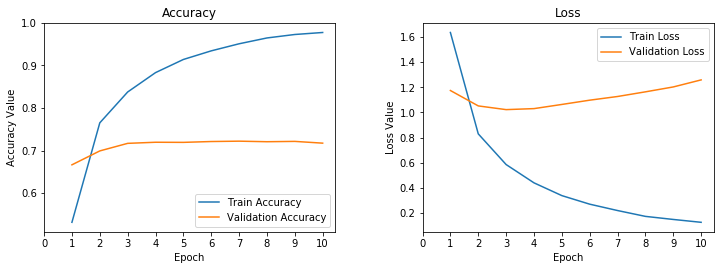

In [90]:
plot_learning_curve(history)

- Poor performance, especially considering number of training parameters ~ 1.5mio
- Not too surprising that this doesn't work well, as flattening the word embeddings loses useful structure. Before flattening, adjacent words are next to each other in the tensor for the layer; afterwards they are separated by 300, the dimension of the embedding.
- Also the fully connected layers are not using the fact that neighboring words are more important compared to distant words

# CNNs

In general, CNN architectures directly take advantage of the closer relationship of neighboring words. 

We'll try 2 different architectures.

## global max pooling

Very similar to:
https://arxiv.org/pdf/1408.5882.pdf

This particular architecture uses different filter sizes for the convolutions, and then takes a global maximum over the sequence. The idea is to find the strongest instance of each convolutional filter.

Finally this is fed into a softmax classification layer.

One advantage of taking a global maximum over the sequence is that we can input the entire sequence, and don't have to truncate the number of words.

In [96]:
MAX_LENGTH = max(max([len(x) for x in train_k]), max([len(x) for x in val_k]))

In [97]:
train = pad_sequences(train_k, maxlen=MAX_LENGTH)
val = pad_sequences(val_k, maxlen=MAX_LENGTH)

In [98]:
train.shape

(40000, 229)

In [99]:
graph_in = Input(shape=(MAX_LENGTH, EMBEDDING_DIM))

In [100]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_weights],
                            input_length=MAX_LENGTH,
                            trainable=False)

In [147]:
filter_sizes = (3, 4, 5)
num_filters = 100

convs = []
for fsz in filter_sizes:
    conv = Conv1D(num_filters, fsz, activation='relu')(graph_in)
    pool = GlobalMaxPooling1D()(conv)
    convs.append(pool)

out = Concatenate()(convs)
graph = Model(input=graph_in, output=out)

C:\Anaconda3\envs\congress\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  # This is added back by InteractiveShellApp.init_path()


In [148]:
model = Sequential()
model.add(embedding_layer)
model.add(graph)
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='softmax'))

In [149]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 52, 300)           14886900  
_________________________________________________________________
model_2 (Model)              (None, 300)               360300    
_________________________________________________________________
dense_27 (Dense)             (None, 50)                15050     
_________________________________________________________________
dense_28 (Dense)             (None, 20)                1020      
Total params: 15,263,270
Trainable params: 376,370
Non-trainable params: 14,886,900
_________________________________________________________________


In [150]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [151]:
history = model.fit(train,
          y_train_cat, 
          validation_data=(val, y_val_cat),
          batch_size=512, 
          epochs=10)

Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 4s 91us/step - loss: 1.5942 - acc: 0.5629 - val_loss: 0.9221 - val_acc: 0.7400
Epoch 2/10
40000/40000 [==============================] - 3s 65us/step - loss: 0.7494 - acc: 0.7855 - val_loss: 0.7247 - val_acc: 0.7900
Epoch 3/10
40000/40000 [==============================] - 3s 65us/step - loss: 0.5700 - acc: 0.8348 - val_loss: 0.6642 - val_acc: 0.8050
Epoch 4/10
40000/40000 [==============================] - 3s 65us/step - loss: 0.4599 - acc: 0.8654 - val_loss: 0.6385 - val_acc: 0.8121
Epoch 5/10
40000/40000 [==============================] - 3s 66us/step - loss: 0.3739 - acc: 0.8905 - val_loss: 0.6175 - val_acc: 0.8189
Epoch 6/10
40000/40000 [==============================] - 3s 66us/step - loss: 0.3038 - acc: 0.9148 - val_loss: 0.6311 - val_acc: 0.8152
Epoch 7/10
40000/40000 [==============================] - 3s 65us/step - loss: 0.2494 - acc: 0.9304 - val_loss: 0.6308 - val_acc

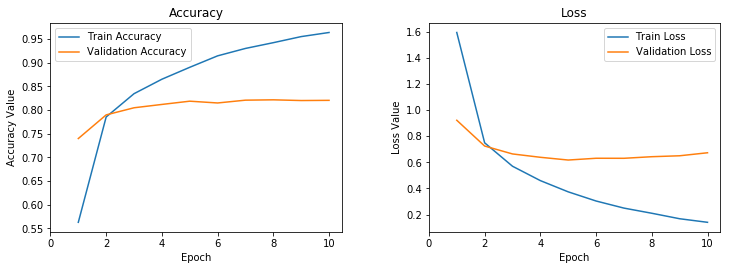

In [152]:
plot_learning_curve(history)

## multi-layer CNN with max pooling

Based on https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

This reduces the length of the sequence by progressive max pooling and using multiple layers.

In [134]:
padding = 'post'
truncating = 'post'

train = pad_sequences(train_k, maxlen=MAX_SEQUENCE_LENGTH, padding=padding, truncating=truncating)
val = pad_sequences(val_k, maxlen=MAX_SEQUENCE_LENGTH, padding=padding, truncating=truncating)

In [135]:
train.shape

(40000, 52)

In [141]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_weights],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [142]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(200, 4, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(200, 4, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(200, 4, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(20, activation='softmax'))

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 52, 300)           14886900  
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 49, 200)           240200    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 16, 200)           0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 13, 200)           160200    
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 4, 200)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 1, 200)            160200    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 200)               0         
__________

In [144]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [145]:
model.fit(train,
          y_train_cat, 
          validation_data=(val, y_val_cat),
          batch_size=128, 
          epochs=10)

Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 5s 115us/step - loss: 1.2918 - acc: 0.6277 - val_loss: 0.8410 - val_acc: 0.7587
Epoch 2/10
40000/40000 [==============================] - 4s 98us/step - loss: 0.6742 - acc: 0.8065 - val_loss: 0.7246 - val_acc: 0.7960
Epoch 3/10
40000/40000 [==============================] - 4s 98us/step - loss: 0.4872 - acc: 0.8581 - val_loss: 0.7275 - val_acc: 0.8051
Epoch 4/10
40000/40000 [==============================] - 4s 97us/step - loss: 0.3493 - acc: 0.8956 - val_loss: 0.7345 - val_acc: 0.8076
Epoch 5/10
40000/40000 [==============================] - 4s 96us/step - loss: 0.2355 - acc: 0.9305 - val_loss: 0.8185 - val_acc: 0.8040
Epoch 6/10
40000/40000 [==============================] - 4s 97us/step - loss: 0.1726 - acc: 0.9502 - val_loss: 0.8404 - val_acc: 0.8035
Epoch 7/10
40000/40000 [==============================] - 4s 96us/step - loss: 0.1334 - acc: 0.9641 - val_loss: 0.9039 - val_ac

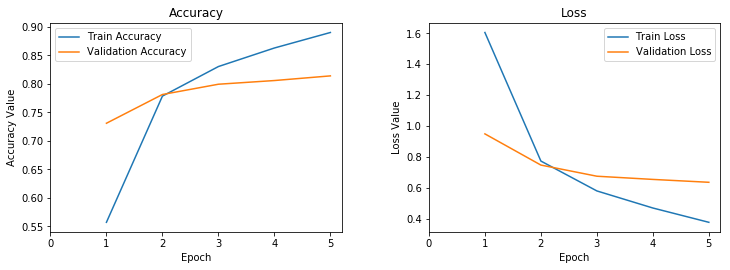

In [146]:
plot_learning_curve(history)

- worse than globalmaxpooling

## k-max pooling

As a final CNN architecture, we return to the idea of global max pooling, but instead of a global max pooling taking only the top result for each feature map, we can take the top k results.

We'll try $k=2$ to see if we get an improvement

In [153]:
# from https://github.com/bicepjai/Deep-Survey-Text-Classification/blob/master/deep_models/paper_02_cnn_sent_model/models.ipynb
from utils import KMaxPooling

In [184]:
train = pad_sequences(train_k, maxlen=MAX_LENGTH)
val = pad_sequences(val_k, maxlen=MAX_LENGTH)

In [185]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_weights],
                            input_length=MAX_LENGTH,
                            trainable=False)

In [196]:
filter_sizes = (3, 4, 5)
num_filters = 100

convs = []
for fsz in filter_sizes:
    conv = Conv1D(num_filters, fsz, activation='relu')(graph_in)
    pool = KMaxPooling(2)(conv)
    convs.append(pool)

out = Concatenate()(convs)
graph = Model(input=graph_in, output=out)

C:\Anaconda3\envs\congress\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  # This is added back by InteractiveShellApp.init_path()


In [197]:
model = Sequential()
model.add(embedding_layer)
model.add(graph)
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='softmax'))

In [198]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 229, 300)          14886900  
_________________________________________________________________
model_6 (Model)              (None, 2, 300)            360300    
_________________________________________________________________
flatten_14 (Flatten)         (None, 600)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 50)                30050     
_________________________________________________________________
dense_50 (Dense)             (None, 20)                1020      
Total params: 15,278,270
Trainable params: 391,370
Non-trainable params: 14,886,900
_________________________________________________________________


In [199]:
history = model.fit(train,
                    y_train_cat, 
                    validation_data=(val, y_val_cat),
                    batch_size=256, 
                    epochs=10)

Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 47s 1ms/step - loss: 1.4868 - acc: 0.5901 - val_loss: 0.9117 - val_acc: 0.7418
Epoch 2/10
40000/40000 [==============================] - 45s 1ms/step - loss: 0.7518 - acc: 0.7849 - val_loss: 0.7648 - val_acc: 0.7795
Epoch 3/10
40000/40000 [==============================] - 45s 1ms/step - loss: 0.5777 - acc: 0.8340 - val_loss: 0.6866 - val_acc: 0.8011
Epoch 4/10
40000/40000 [==============================] - 45s 1ms/step - loss: 0.4605 - acc: 0.8664 - val_loss: 0.6576 - val_acc: 0.8107
Epoch 5/10
40000/40000 [==============================] - 45s 1ms/step - loss: 0.3739 - acc: 0.8909 - val_loss: 0.6577 - val_acc: 0.8117
Epoch 6/10
40000/40000 [==============================] - 45s 1ms/step - loss: 0.2958 - acc: 0.9153 - val_loss: 0.6708 - val_acc: 0.8127
Epoch 7/10
40000/40000 [==============================] - 45s 1ms/step - loss: 0.2369 - acc: 0.9333 - val_loss: 0.7196 - val_acc

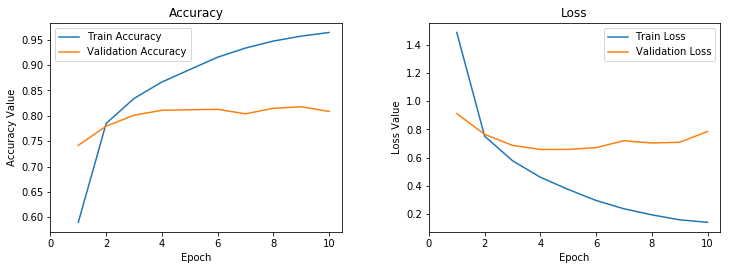

In [200]:
plot_learning_curve(history)

- still worse than globalmaxpooling

## CNN summary

Similar to https://arxiv.org/pdf/1510.03820.pdf, we find that global max pooling works best.

The same paper also provides some other useful recommendations if we want to fine tune the model hyperparameters:
- filter size is important 1-10. find best filter size, then use that and surrounding sizes.
- number of filters from 100 to 600
- dropout between 0.1 to 0.5, but not too important; l2 not helpful

# RNN - bidirectional LSTM

We'll try a standard LSTM architecture too.

In [201]:
MAX_SEQUENCE_LENGTH = 52

In [202]:
padding = 'post'
truncating = 'post'

train = pad_sequences(train_k, maxlen=MAX_SEQUENCE_LENGTH, padding=padding, truncating=truncating)
val = pad_sequences(val_k, maxlen=MAX_SEQUENCE_LENGTH, padding=padding, truncating=truncating)

In [203]:
from keras.layers import LSTM
from keras.layers import Bidirectional

In [204]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_weights],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [205]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(MAX_SEQUENCE_LENGTH, return_sequences=True)))
model.add(Bidirectional(LSTM(MAX_SEQUENCE_LENGTH, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(20, activation='softmax'))

In [206]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 52, 300)           14886900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 52, 104)           146848    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 52, 104)           65312     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 104)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 20)                2100      
Total params: 15,101,160
Trainable params: 214,260
Non-trainable params: 14,886,900
_________________________________________________________________


In [207]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [208]:
history = model.fit(train,
                  y_train_cat, 
                  validation_data=(val, y_val_cat),
                  batch_size=128, 
                  epochs=10)

Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 125s 3ms/step - loss: 1.5062 - acc: 0.5720 - val_loss: 0.9952 - val_acc: 0.7179
Epoch 2/10
40000/40000 [==============================] - 123s 3ms/step - loss: 0.8649 - acc: 0.7510 - val_loss: 0.8198 - val_acc: 0.7631
Epoch 3/10
40000/40000 [==============================] - 121s 3ms/step - loss: 0.7143 - acc: 0.7940 - val_loss: 0.7431 - val_acc: 0.7829
Epoch 4/10
40000/40000 [==============================] - 121s 3ms/step - loss: 0.6287 - acc: 0.8143 - val_loss: 0.6956 - val_acc: 0.7948
Epoch 5/10
40000/40000 [==============================] - 118s 3ms/step - loss: 0.5615 - acc: 0.8322 - val_loss: 0.6790 - val_acc: 0.8021
Epoch 6/10
40000/40000 [==============================] - 120s 3ms/step - loss: 0.5086 - acc: 0.8486 - val_loss: 0.6638 - val_acc: 0.8052
Epoch 7/10
40000/40000 [==============================] - 122s 3ms/step - loss: 0.4600 - acc: 0.8615 - val_loss: 0.6661 - 

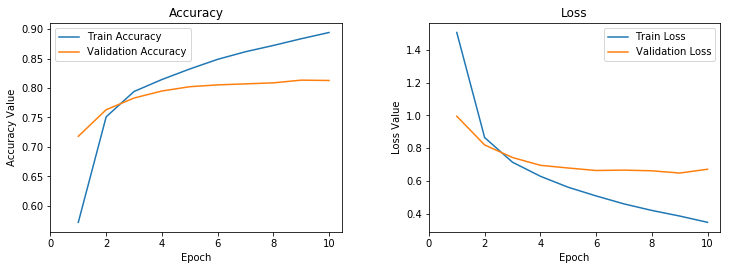

In [209]:
plot_learning_curve(history)

- comparable to CNNs

# Bert

https://arxiv.org/abs/1810.04805

Try 2 approaches:
1. feature-based approach - see section 5.4 of the bert paper. Just as in the Bert paper, we can try taking the last layer, or the penultimate layer, or adding the last few layers, or concatening the last few layers.
2. fine-tune bert - either fine tune all the layers as suggested in the Bert paper, using a low learning rate. Or freeze all but the top few hidden layers and train just those.

## tokenizer

In [14]:
MAX_SEQUENCE_LENGTH = 52

In [15]:
from keras_bert import load_trained_model_from_checkpoint

pretrained_model_path = Path(r"D:\data\uncased_L-12_H-768_A-12")

config_path = pretrained_model_path / "bert_config.json"
checkpoint_path = pretrained_model_path / "bert_model.ckpt"
dict_path = pretrained_model_path / "vocab.txt"

In [16]:
from keras_bert import Tokenizer
import codecs

token_dict = {} 
with codecs.open(dict_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

tokenizer = Tokenizer(token_dict)

In [17]:
texts = ["This here's an example of using the BERT tokenizer", "affable"]
tokens = [tokenizer.tokenize(text) for text in texts]
tokens

[['[CLS]',
  'this',
  'here',
  "'",
  's',
  'an',
  'example',
  'of',
  'using',
  'the',
  'bert',
  'token',
  '##izer',
  '[SEP]'],
 ['[CLS]', 'af', '##fa', '##ble', '[SEP]']]

In [18]:
indices_segments = [tokenizer.encode(first=text, max_len=MAX_SEQUENCE_LENGTH) for text in texts]
indices, segments = zip(*indices_segments)
indices = np.asarray(indices)
segments = np.asarray(segments)

In [19]:
def get_input(texts):
    indices_segments = [tokenizer.encode(first=text, max_len=52) for text in texts]
    indices, segments = zip(*indices_segments)
    indices = np.asarray(indices)
    segments = np.asarray(segments)
    return [indices, segments]

In [20]:
train_indices, _ = get_input(X_train['description'])
val_indices, _ = get_input(X_val['description'])

## feature-based approach

In [16]:
bert = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=MAX_SEQUENCE_LENGTH)
bert.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 52)           0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 52)           0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 52, 768), (3 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 52, 768)      1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [17]:
predictions = bert.predict([indices, np.zeros(indices.shape)])
predictions.shape

(2, 52, 768)

In [85]:
output = Concatenate()([bert.layers[-1].output, bert.layers[-2].output, bert.layers[-3].output])
# output = Add()([bert.layers[-1].output, bert.layers[-2].output, bert.layers[-3].output])

bert_model = Model(bert.input, output)
bert_model.trainable = False

for layer in bert_model.layers:
    layer.trainable = False
    
bert_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 52)           0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 52)           0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 52, 768), (3 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 52, 768)      1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [86]:
x = bert_model(bert.input)
# x = Lambda(lambda x: x[:,0,:])(x) # to select one element only
model = Model(bert.input, x)

In [87]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in bert_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002565D50DC50>,Input-Token,False
1,<keras.engine.input_layer.InputLayer object at 0x000002565D50DF60>,Input-Segment,False
2,<keras_bert.layers.embedding.TokenEmbedding object at 0x00000256350DACF8>,Embedding-Token,False
3,<keras.layers.embeddings.Embedding object at 0x0000025640608550>,Embedding-Segment,False
4,<keras.layers.merge.Add object at 0x0000025640608198>,Embedding-Token-Segment,False
5,<keras_pos_embd.pos_embd.PositionEmbedding object at 0x00000256406089E8>,Embedding-Position,False
6,<keras.layers.core.Dropout object at 0x00000256406085F8>,Embedding-Dropout,False
7,<keras_layer_normalization.layer_normalization.LayerNormalization object at 0x0000025640644CF8>,Embedding-Norm,False
8,<keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x0000025640608D68>,Encoder-1-MultiHeadSelfAttention,False
9,<keras.layers.core.Dropout object at 0x0000025640608518>,Encoder-1-MultiHeadSelfAttention-Dropout,False


In [88]:
train_embeddings = model.predict([train_indices, np.zeros(train_indices.shape)])

In [90]:
val_embeddings = model.predict([val_indices, np.zeros(val_indices.shape)])

In [ ]:
train_embeddings.shape

In [111]:
graph_in = Input(shape=(train_embeddings.shape[1], train_embeddings.shape[2]))
graph_in

<tf.Tensor 'input_6:0' shape=(?, 52, 2304) dtype=float32>

In [116]:
filter_sizes = (3, 4, 5)
num_filters = 100

convs = []
for fsz in filter_sizes:
    conv = Conv1D(num_filters, fsz, activation='relu')(graph_in)
    pool = GlobalMaxPooling1D()(conv)
    convs.append(pool)

out = Concatenate()(convs)
graph = Model(input=graph_in, output=out)

C:\Anaconda3\envs\congress\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  # This is added back by InteractiveShellApp.init_path()


In [113]:
model = Sequential()
model.add(graph)
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='softmax'))

In [114]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_22 (Model)             (None, 300)               2765100   
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                15050     
_________________________________________________________________
dense_14 (Dense)             (None, 20)                1020      
Total params: 2,781,170
Trainable params: 2,781,170
Non-trainable params: 0
_________________________________________________________________


In [95]:
history = model.fit(train_embeddings,
          y_train_cat, 
          validation_data=(val_embeddings, y_val_cat),
          batch_size=128, 
          epochs=10)

Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 172s 4ms/step - loss: 1.6759 - acc: 0.5114 - val_loss: 0.9224 - val_acc: 0.7391
Epoch 2/10
40000/40000 [==============================] - 203s 5ms/step - loss: 0.8040 - acc: 0.7705 - val_loss: 0.7250 - val_acc: 0.7873
Epoch 3/10
40000/40000 [==============================] - 178s 4ms/step - loss: 0.6244 - acc: 0.8183 - val_loss: 0.7081 - val_acc: 0.7945
Epoch 4/10
40000/40000 [==============================] - 218s 5ms/step - loss: 0.5210 - acc: 0.8465 - val_loss: 0.6800 - val_acc: 0.8085
Epoch 5/10
40000/40000 [==============================] - 219s 5ms/step - loss: 0.4346 - acc: 0.8690 - val_loss: 0.6848 - val_acc: 0.8095
Epoch 6/10
40000/40000 [==============================] - 186s 5ms/step - loss: 0.3728 - acc: 0.8848 - val_loss: 0.7105 - val_acc: 0.8124
Epoch 7/10
40000/40000 [==============================] - 178s 4ms/step - loss: 0.3184 - acc: 0.9016 - val_loss: 0.7156 - 

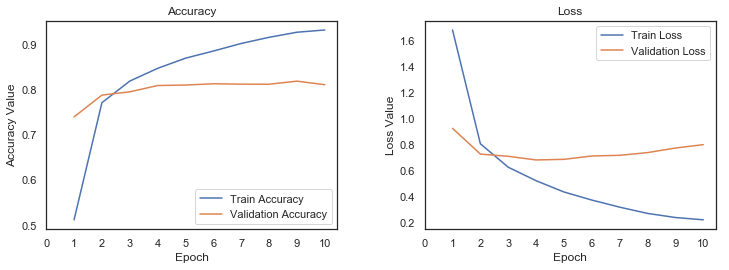

In [96]:
plot_learning_curve(history, 10)

from best to worst:
- taking the last layer (~83%)
- adding the last 3 layers (~82.5%)
- taking the penultimate layer (~82%)
- concatenating the last 3 layers (~81%)

## fine tuning approach

In [21]:
bert = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=MAX_SEQUENCE_LENGTH)

In [22]:
output = bert.layers[-1].output
bert_model = Model(bert.input, output)
bert_model.trainable = True

for layer in bert_model.layers:
    layer.trainable = False
    
bert_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 52)           0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 52)           0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 52, 768), (3 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 52, 768)      1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [23]:
bert_model.trainable = True

set_trainable = False
for layer in bert_model.layers:
    if layer.name=='Embedding-Token': # 'Encoder-9-MultiHeadSelfAttention':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
layers = [(layer, layer.name, layer.trainable) for layer in bert_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002FA83A9C7B8>,Input-Token,False
1,<keras.engine.input_layer.InputLayer object at 0x000002FA83A9CF60>,Input-Segment,False
2,<keras_bert.layers.embedding.TokenEmbedding object at 0x000002FAFB4AE438>,Embedding-Token,True
3,<keras.layers.embeddings.Embedding object at 0x000002FA83A9C550>,Embedding-Segment,True
4,<keras.layers.merge.Add object at 0x000002FA83A9CB00>,Embedding-Token-Segment,True
5,<keras_pos_embd.pos_embd.PositionEmbedding object at 0x000002FA83A9CE48>,Embedding-Position,True
6,<keras.layers.core.Dropout object at 0x000002FA83A9CEF0>,Embedding-Dropout,True
7,<keras_layer_normalization.layer_normalization.LayerNormalization object at 0x000002FA83A9C5C0>,Embedding-Norm,True
8,<keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x000002FA83A9CF28>,Encoder-1-MultiHeadSelfAttention,True
9,<keras.layers.core.Dropout object at 0x000002FAA4F505C0>,Encoder-1-MultiHeadSelfAttention-Dropout,True


In [25]:
x = bert_model(bert.input)
x = Lambda(lambda x: x[:,0,:])(x) # this corresponds to the position of the [CLS] token
preds = Dense(20, activation='softmax')(x)

In [26]:
model = Model(bert.input, preds)

choose a low learning rate to avoid large adjustments of the pre-trained weights.

In [27]:
model.compile(optimizer=Adam(lr=1e-5), # choose a low learning rate
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 52)           0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 52)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 52, 768)      108538368   Input-Token[0][0]                
                                                                 Input-Segment[0][0]              
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768)          0           model_2[1][0]                    
__________

In [30]:
history = model.fit([train_indices, np.zeros(train_indices.shape)],
          y_train_cat,
          validation_data=([val_indices, np.zeros(val_indices.shape)], y_val_cat),
          batch_size=8,
          epochs=3)

Train on 40000 samples, validate on 40000 samples
Epoch 1/2
40000/40000 [==============================] - 1369s 34ms/step - loss: 0.4620 - acc: 0.8621 - val_loss: 0.5742 - val_acc: 0.8340
Epoch 2/2
40000/40000 [==============================] - 1364s 34ms/step - loss: 0.3236 - acc: 0.9023 - val_loss: 0.5819 - val_acc: 0.8408


Bert is best!